In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using same beta from article, same $r_m, t_m, d_m$ data, just modified to fit an SEIR model

In [22]:
gamma=1/10

#defining beta as a function of time as a gaussian distribution (from the article on Github)
#r_m, t_m, d_m from article are gauss_height, t_centers, gauss_width

def make_beta_func(gauss_height, t_centers, gauss_width):
    gauss_height = np.asarray(gauss_height, dtype=float)
    t_centers = np.asarray(t_centers, dtype=float)
    gauss_width = np.asarray(gauss_width, dtype=float)

    def beta(t):
        return np.sum(
            gauss_height * np.exp(-((t - t_centers)**2) / (gauss_width**2))
        )

    return beta

# SEIR Gaussian $\beta(t)$, RK4 method

In [40]:
def SEIRRK4_time_dependent_beta(i0, N, nbjours, beta_func, sigma, gamma, e0=0):

    dt = 1
    S = np.zeros(nbjours)
    E = np.zeros(nbjours)
    I = np.zeros(nbjours)
    R = np.zeros(nbjours)

    I[0] = i0
    E[0] = e0
    R[0] = 0
    S[0] = N - i0 - e0

    for i in range(nbjours - 1):

        t = i * dt
        b1 = beta_func(t)
        b2 = beta_func(t + 0.5 * dt)
        b3 = b2
        b4 = beta_func(t + dt)

        # ----- k1 -----
        k1_S = (-b1 * S[i] * I[i] / N) * dt
        k1_E = (b1 * S[i] * I[i] / N - sigma * E[i]) * dt
        k1_I = (sigma * E[i] - gamma * I[i]) * dt
        k1_R = (gamma * I[i]) * dt

        S1 = S[i] + 0.5 * k1_S
        E1 = E[i] + 0.5 * k1_E
        I1 = I[i] + 0.5 * k1_I
        R1 = R[i] + 0.5 * k1_R

        # ----- k2 -----
        k2_S = (-b2 * S1 * I1 / N) * dt
        k2_E = (b2 * S1 * I1 / N - sigma * E1) * dt
        k2_I = (sigma * E1 - gamma * I1) * dt
        k2_R = (gamma * I1) * dt

        S2 = S[i] + 0.5 * k2_S
        E2 = E[i] + 0.5 * k2_E
        I2 = I[i] + 0.5 * k2_I
        R2 = R[i] + 0.5 * k2_R

        # ----- k3 -----
        k3_S = (-b3 * S2 * I2 / N) * dt
        k3_E = (b3 * S2 * I2 / N - sigma * E2) * dt
        k3_I = (sigma * E2 - gamma * I2) * dt
        k3_R = (gamma * I2) * dt

        S3 = S[i] + k3_S
        E3 = E[i] + k3_E
        I3 = I[i] + k3_I
        R3 = R[i] + k3_R

        # ----- k4 -----
        k4_S = (-b4 * S3 * I3 / N) * dt
        k4_E = (b4 * S3 * I3 / N - sigma * E3) * dt
        k4_I = (sigma * E3 - gamma * I3) * dt
        k4_R = (gamma * I3) * dt

        # Update
        S[i+1] = S[i] + (k1_S + 2*k2_S + 2*k3_S + k4_S) / 6
        E[i+1] = E[i] + (k1_E + 2*k2_E + 2*k3_E + k4_E) / 6
        I[i+1] = I[i] + (k1_I + 2*k2_I + 2*k3_I + k4_I) / 6
        R[i+1] = R[i] + (k1_R + 2*k2_R + 2*k3_R + k4_R) / 6

    return S, E, I, R

In [41]:
N = 100000
i0 = 10
e0 = 5
nbjours = 200

# Gaussian parameters
gauss_height_values = [0.01, 0.28, 0.19, 0.25, 0.04, 0.03, 0.03, 0.02, 0.02, 0.06, 0.01, 0.01, 0.02, 0.01, 0.02]
t_center = [0, 12, 44, 49, 160, 299, 457, 565, 718, 723, 787, 846, 916, 989, 1061]
gauss_width_values = [12, 18, 49, 23, 54, 89, 39, 50, 93, 19, 14, 9, 45, 29, 42]
beta_func = make_beta_func(gauss_height_values, t_center, gauss_width_values)

# SEIR parameters
sigma = 1/5
gamma = 1/14

# Run model
S, E, I, R = SEIRRK4_time_dependent_beta(i0, N, nbjours, beta_func, sigma, gamma, e0=e0)

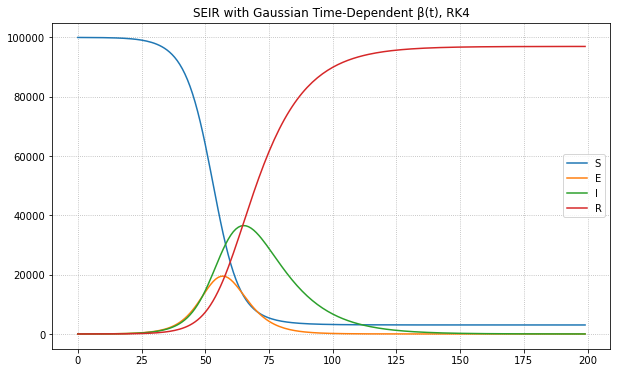

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(S, label="S")
plt.plot(E, label="E")
plt.plot(I, label="I")
plt.plot(R, label="R")
plt.legend()
plt.title("SEIR with Gaussian Time-Dependent β(t), RK4")
plt.grid(True, linestyle=":")
plt.show()

# SEIR Gaussian $\beta(t)$, RK2 method

In [43]:
def SEIRRK2_time_dependent_beta(i0, N, nbjours, beta_func, sigma, gamma, e0=0):

    dt = 1
    # Creation of lists
    S = np.zeros(nbjours)
    E = np.zeros(nbjours)
    I = np.zeros(nbjours)
    R = np.zeros(nbjours)

    # Initial Conditions
    I[0] = i0
    E[0] = e0
    R[0] = 0
    S[0] = N - i0 - e0 - R[0]

    for i in range(nbjours - 1):

        t = i * dt
        b1 = beta_func(t)          # beta for k1
        b2 = beta_func(t + dt)     # beta for k2

        # --- k1 ---
        k1_S = (-b1 * S[i] * I[i]) / N * dt
        k1_E = (b1 * S[i] * I[i] / N - sigma * E[i]) * dt
        k1_I = (sigma * E[i] - gamma * I[i]) * dt
        k1_R = (gamma * I[i]) * dt

        # U + k1
        S_k1 = S[i] + k1_S
        E_k1 = E[i] + k1_E
        I_k1 = I[i] + k1_I
        R_k1 = R[i] + k1_R

        # --- k2 ---
        k2_S = (-b2 * S_k1 * I_k1) / N * dt
        k2_E = (b2 * S_k1 * I_k1 / N - sigma * E_k1) * dt
        k2_I = (sigma * E_k1 - gamma * I_k1) * dt
        k2_R = (gamma * I_k1) * dt

        # --- Update ---
        S[i+1] = S[i] + 0.5 * (k1_S + k2_S)
        E[i+1] = E[i] + 0.5 * (k1_E + k2_E)
        I[i+1] = I[i] + 0.5 * (k1_I + k2_I)
        R[i+1] = R[i] + 0.5 * (k1_R + k2_R)

    return S, E, I, R

In [44]:
N = 100000
i0 = 10
e0 = 5
nbjours = 200

# Gaussian parameters
gauss_height_values = [0.01, 0.28, 0.19, 0.25, 0.04, 0.03, 0.03, 0.02, 0.02, 0.06, 0.01, 0.01, 0.02, 0.01, 0.02]
t_center = [0, 12, 44, 49, 160, 299, 457, 565, 718, 723, 787, 846, 916, 989, 1061]
gauss_width_values = [12, 18, 49, 23, 54, 89, 39, 50, 93, 19, 14, 9, 45, 29, 42]
beta_func = make_beta_func(gauss_height_values, t_center, gauss_width_values)

# SEIR parameters
sigma = 1/5
gamma = 1/14

S, E, I, R = SEIRRK2_time_dependent_beta(i0, N, nbjours, beta_func, sigma, gamma, e0)

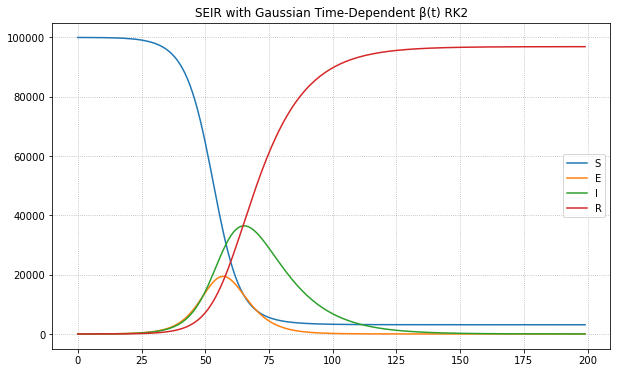

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(S, label="S")
plt.plot(E, label="E")
plt.plot(I, label="I")
plt.plot(R, label="R")
plt.legend()
plt.title("SEIR with Gaussian Time-Dependent β(t) RK2")
plt.grid(True, linestyle=":")
plt.show()

# SEIR Gaussian $\beta(t)$, Modified Euler method

In [50]:
def seir_model_time_dependent_beta(i0, N, nbjours, beta_func, sigma, gamma, e0=0):

    # Creation of lists
    S = np.zeros(nbjours)
    E = np.zeros(nbjours)
    I = np.zeros(nbjours)
    R = np.zeros(nbjours)

    # Initial Condition
    I[0] = i0
    E[0] = e0
    R[0] = 0
    S[0] = N - i0 - e0 - R[0]

    # Propagation
    for i in range(nbjours - 1):

        t = i
        beta = beta_func(t)

        S[i+1] = S[i] - beta * I[i] * S[i] / N
        E[i+1] = E[i] + beta * I[i] * S[i] / N - sigma * E[i]
        I[i+1] = I[i] + sigma * E[i] - gamma * I[i]
        R[i+1] = R[i] + gamma * I[i]

    return S, E, I, R

In [51]:
N = 100000
i0 = 10
e0 = 5
nbjours = 200

# Gaussian parameters
gauss_height_values = [0.01, 0.28, 0.19, 0.25, 0.04, 0.03, 0.03, 0.02, 0.02, 0.06, 0.01, 0.01, 0.02, 0.01, 0.02]
t_center = [0, 12, 44, 49, 160, 299, 457, 565, 718, 723, 787, 846, 916, 989, 1061]
gauss_width_values = [12, 18, 49, 23, 54, 89, 39, 50, 93, 19, 14, 9, 45, 29, 42]
beta_func = make_beta_func(gauss_height_values, t_center, gauss_width_values)

# SEIR parameters
sigma = 1/5
gamma = 1/14

S, E, I, R = seir_model_time_dependent_beta(i0, N, nbjours, beta_func, sigma, gamma, e0)

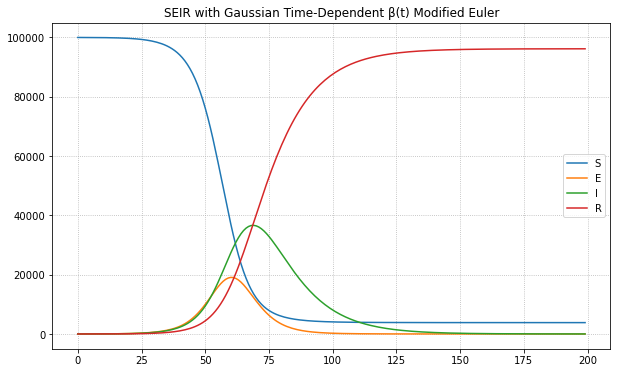

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(S, label="S")
plt.plot(E, label="E")
plt.plot(I, label="I")
plt.plot(R, label="R")
plt.legend()
plt.title("SEIR with Gaussian Time-Dependent β(t) Modified Euler")
plt.grid(True, linestyle=":")
plt.show()

# Comparing efficiency

In [53]:
import time

def time_solver(name, solver):
    start = time.perf_counter()
    S, E, I, R = solver(i0, N, nbjours, beta_func, sigma, gamma, e0=0)
    end = time.perf_counter()
    print(f"{name} time: {end - start:.6f} seconds")

# comparing three methods
time_solver("RK4", SEIRRK4_time_dependent_beta)
time_solver("RK2", SEIRRK2_time_dependent_beta)
time_solver("Modified Euler", seir_model_time_dependent_beta)

RK4 time: 0.006425 seconds
RK2 time: 0.004311 seconds
Modified Euler time: 0.002308 seconds
